# Network waterfall generation

In [24]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt
import re, bisect
from colorama import Fore

## Select input file and experiment ID (~10 experiments per file)
- ./startup : Application startup
- ./startup_and_click : Application startup + click (single user interaction)
- ./multiclick : Application statup + clicks (multiple user interactions)

### (*critical flows* and performance metrics available for *startup* and *startup_and_click* datasets)

In [49]:
##example (YouTube)
FNAME = "./startup/com.google.android.youtube_bursts.txt"
EXPID = 1

## Load experiment data and plot waterfall

TDT = Transport Delivery Time
AFT = Above-the-Fold Time
Critical flows
Non-Critical flows


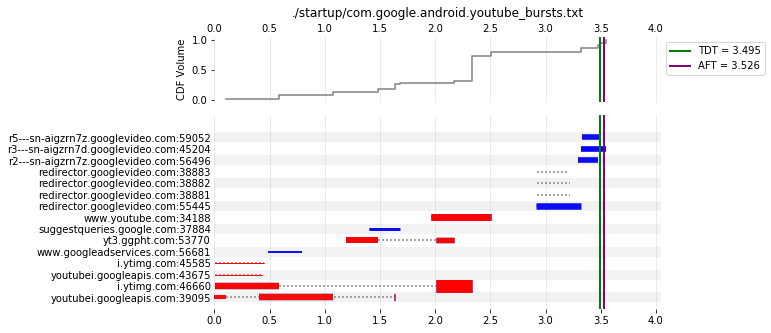

In [48]:
##load experiment data
d_exps = load_experiments(FNAME)
df = d_exps[EXPID]
print_head(FNAME)
##plot waterfall
plot_waterfall(df, fvolume=None, title=FNAME, fname_png="output_waterfall.png")

## A small library for plotting waterfalls, based on matplotlib

In [50]:
def load_experiments(fname):
    df = pd.read_csv(fname, sep = ' ', low_memory=False)
    ## split the single file in multiple dataframes based on experiment id
    d = {}
    for expid in df['expId'].unique():
        df_tmp = df[df['expId'] == expid].copy()
        df_tmp = df_tmp.sort_values(by='t_start')
        
        cat = pd.Categorical(df_tmp['flow'], ordered=False)
        cat = cat.reorder_categories(df_tmp['flow'].unique())
        df_tmp.loc[:, 'flowid'] = cat.codes
        
        d[expid] = df_tmp
    return d



def _get_reference_times(df):
    tdt = df['TDT'].values[0]
    aft = df['AFT'].values[0]
    x_max = 0.5+max(df['t_end'].max(), aft, tdt)
    return {
        'tdt' : tdt,
        'aft' : aft,
        'x_max' : x_max}


def _get_max_time(df):
    x_max = 0.5+df['t_end'].max()
    return {'x_max' : x_max}
    

def _get_lines_burst(df, x_lim=None):
    lines_burst = []
    lines_burst_widths = []
    for flowid, x_start, x_end, burst_bytes in df[['flowid', 't_start', 't_end', 'KB']].values:
        if x_lim is None:
            lines_burst.append([(x_start, flowid), (x_end, flowid)])
            width = min(13, 2*sqrt(burst_bytes))
            width = max(1, width)
            lines_burst_widths.append(width)
        else:
            el = [(x_lim[0], flowid), (x_lim[1], flowid)]
            if el not in lines_burst:
                lines_burst.append(el)

    return lines_burst, lines_burst_widths



def _plot_aft_tdt_reference(ax, tdt, aft, no_legend=False):
    tdt_label = "TDT = " + str(tdt)[0:5]
    aft_label = "AFT = " + str(aft)[0:5]
    if no_legend:
        tdt_label = None
        aft_label = None
    ax.axvline(x=tdt, color="green", label=tdt_label, linewidth=2) #, ax = ax)
    ax.axvline(x=aft, color="purple", label=aft_label, linewidth=2) #, ax = ax)
    lgd = ax.legend(bbox_to_anchor=[1, 1])

    
def _plot_bursts(ax, df, lines_flow, 
                 lines_burst=None, 
                 lines_burst_critical=None,
                 flow_kwargs={}, 
                 burst_kwargs={}, 
                 burst_critical_kwargs={},
                 title=None):
    ## flow lines
    ax.add_collection(mpl.collections.LineCollection(lines_flow, **flow_kwargs)) 

    ## burst lines
    if lines_burst is not None:
        ax.add_collection(mpl.collections.LineCollection(lines_burst, **burst_kwargs))

    if lines_burst_critical is not None:
        ax.add_collection(mpl.collections.LineCollection(lines_burst_critical, **burst_critical_kwargs))
    
    if 'AFT' in df and 'TDT' in df:
        d_times = _get_reference_times(df)
        ## vertical reference lines
        _plot_aft_tdt_reference(ax, tdt=d_times['tdt'], aft=d_times['aft'])
    else:
        d_times = _get_max_time(df)
    ## axis lim    
    x_max = d_times['x_max']
    y_max = len(lines_flow)+1
    ax.set_ylim((-1, y_max))
    ax.set_xlim((0, x_max))

    chess_lines = [[(0, y),(x_max, y)] for y in range(0, y_max, 2)]
    ax.add_collection(mpl.collections.LineCollection(chess_lines, linewidths=10, color='gray', alpha=0.1))

    ## ticks
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    ax.tick_params(axis='y', length=0)

    ## y-labels (clipping the long ones)
    labels = df[['flow', 'flowid']].sort_values(by='flowid').drop_duplicates()['flow'].values
    ax.set_yticklabels(['',''] + list(labels))

    ## remove borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ## grid
    ax.grid(axis='x', alpha=0.3)

    ax.legend().remove()

    
    
def _plot_volume(ax, df, title=None, fvolume=None):
    ## get times
    if 'AFT' in df and 'TDT' in df:
        d_times = _get_reference_times(df)
    else:
        d_times = _get_max_time(df)
    if fvolume!=None:
        x=[]
        y=[]
        for line in open(fvolume):
            x.append(float(line[0:-1].split(' ')[0]))
            y.append(float(line[0:-1].split(' ')[1]))
        ax.step(x, y, color='gray', where='post', label='')
    else:
        # get volume cumulate
        df_tmp = df.copy()
        df_tmp = df_tmp.sort_values(by='t_end')
        df_tmp.loc[:, 'KB_cdf'] = df_tmp['KB'].cumsum() / df_tmp['KB'].sum()
        ax.step(x=df_tmp['t_end'], y=df_tmp['KB_cdf'], color='gray', where='post', label='')
        
    ## remove border
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    if 'AFT' in df and 'TDT' in df:
        _plot_aft_tdt_reference(ax, tdt=d_times['tdt'], aft=d_times['aft'], no_legend=False)

    ax.tick_params(labeltop=True, labelbottom=False, length=0.1, axis='x', direction='out')
    ax.set_xlim((0, d_times['x_max']))
    
    ## grid
    ax.grid(axis='x', alpha=0.3)
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
    ax.set_ylabel('CDF Volume')
    ## title
    if title is not None:
        ax.set_title(title, pad=20)

        
def print_head(fname):
    print("TDT = Transport Delivery Time\nAFT = Above-the-Fold Time")
    if 'multiclick' not in fname:
        print(Fore.RED + 'Critical flows')
        print(Fore.BLUE + 'Non-Critical flows')
    

def plot_waterfall(df, fvolume=None, title=None, fname_png=None): #, ax=None):
    ## first start and end of each flow
    df_tmp = df.groupby('flowid').agg({'t_start':'min', 't_end':'max'})
    ## ..and create lines
    lines_flow = [ [(x_start, y), (x_end, y)] for y, (x_start, x_end) in zip(df_tmp.index, df_tmp.values) ]
    
    ## lines for each burst
    lines_burst, lines_burst_widths = _get_lines_burst(df[df['KB'] > 0])
    ## lines for each critical burst (if any info on critical domains in the input file)
    if 'critical' in df:
        lines_burst_critical, lines_burst_widths_critical = _get_lines_burst(df[(df['critical']) & (df['KB'] > 0)])
    else:
        lines_burst_critical, lines_burst_widths_critical = [], []
    ######################
    
    fig_height = max(5, 0.25*len(lines_flow))
    fig = plt.figure(figsize=(8, fig_height))
    gs = mpl.gridspec.GridSpec(nrows=2, ncols=1, hspace=0.1, height_ratios=[1,3])
    
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    
    _plot_volume(ax0, df, title, fvolume)
    
    _plot_bursts(ax1, df, lines_flow, lines_burst, lines_burst_critical,
        flow_kwargs={
            'linewidths':2, 
            'color': 'gray', 
            'linestyle' : (0, (1, 1)), 
            'alpha':0.7},
        burst_kwargs={
            'linewidths' : lines_burst_widths, 
            'color': 'blue'},
        burst_critical_kwargs={
            'linewidths':lines_burst_widths_critical, 
            'color': 'red'})
    ## add click timestamps (if any)
    if 'clicks' in df:
        for click_t in df['clicks'].values[0][1:-1].split(', '):
            if float(click_t)<40 and float(click_t)>35:
                continue
            plt.axvline(x=float(click_t), color="grey", linestyle="--")
    if fname_png is not None:
        plt.savefig(fname_png, bbox_inches='tight')